In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.arima.model import ARIMA

# importing the teleco_time_series.csv through the file path
teleco_time_series = pd.read_csv('/Users/justinhuynh/Desktop/teleco_time_series.csv')
# check all information about this file
teleco_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


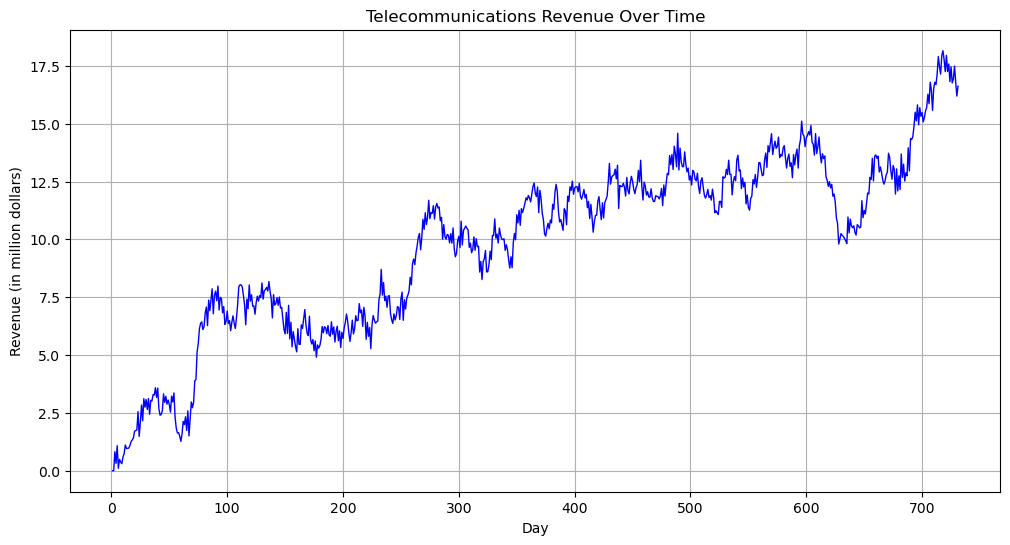

In [97]:
# plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(teleco_time_series['Day'], teleco_time_series['Revenue'], color='blue', linewidth=1)
plt.title('Telecommunications Revenue Over Time')
plt.xlabel('Day')
plt.ylabel('Revenue (in million dollars)')
plt.grid(True)
plt.show()

In [98]:
# perform the Augmented Dickey-Fuller test
adf_result = adfuller(teleco_time_series['Revenue'])

# display the ADF test results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.9246121573101873
p-value: 0.32057281507939484
Critical Values:
   1%: -3.4393520240470554
   5%: -2.8655128165959236
   10%: -2.5688855736949163


In [99]:
# apply first-order differencing
teleco_time_series['Revenue_diff'] = teleco_time_series['Revenue'].diff().dropna()

# drop NaN values created by differencing
teleco_time_series_diff = teleco_time_series.dropna()

# split the data (80% training, 20% testing)
split_point = int(len(teleco_time_series_diff) * 0.8)
train_set = teleco_time_series_diff[:split_point]
test_set = teleco_time_series_diff[split_point:]

# display the first few rows of the training set
train_set.head()

,Day,Revenue,Revenue_diff
1,2,0.000793,0.000793
2,3,0.825542,0.824749
3,4,0.320332,-0.505210
4,5,1.082554,0.762222
5,6,0.107654,-0.974900


In [100]:
# save the cleaned and prepared dataset
train_set.to_csv('cleaned_teleco_time_series_train_d213_task1.csv', index=False)
test_set.to_csv('cleaned_teleco_time_series_test_d213_task1.csv', index=False)

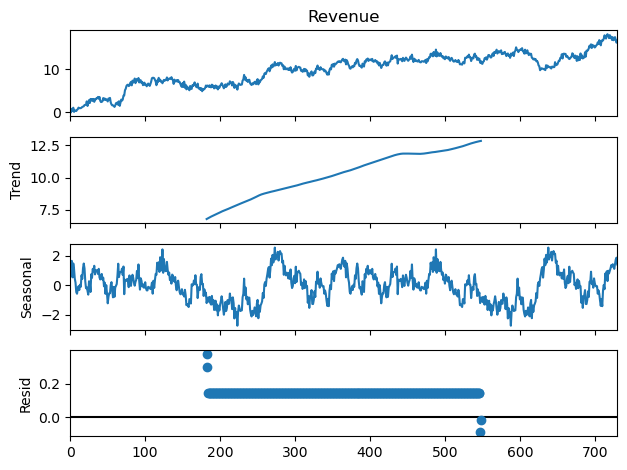

In [101]:
# decompose the full dataset
decomposition = seasonal_decompose(teleco_time_series['Revenue'], model='additive', period=365)
decomposition.plot()
plt.show()

# check the seasonal component 
seasonal_component = decomposition.seasonal

# trends
trend_component = decomposition.trend

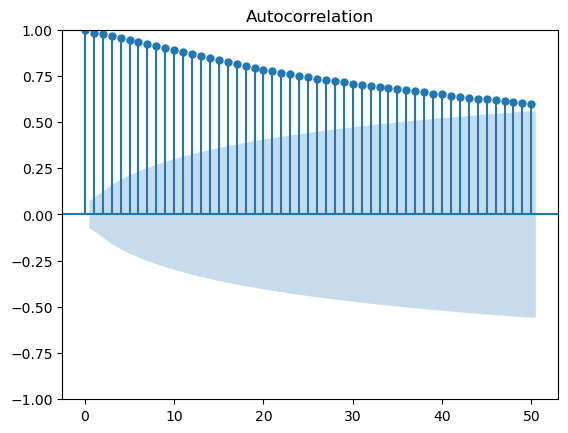

In [102]:
# plot the ACF for the original revenue data
plot_acf(teleco_time_series['Revenue'].dropna(), lags=50)
plt.show()

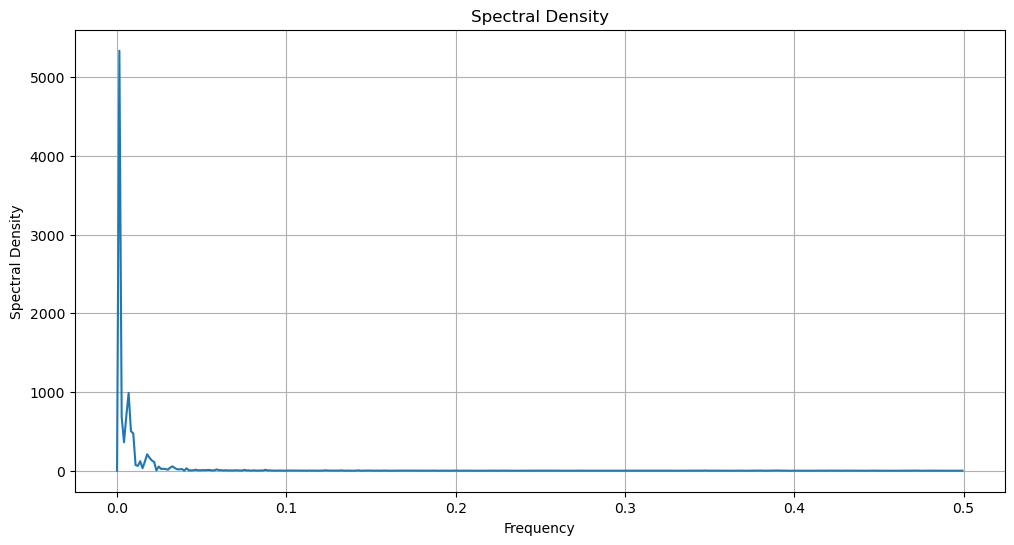

In [103]:
# compute the periodogram
frequencies, spectrum = periodogram(teleco_time_series['Revenue'].dropna())

# plot the spectral density
plt.figure(figsize=(12, 6))
plt.plot(frequencies, spectrum)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.grid(True)
plt.show()

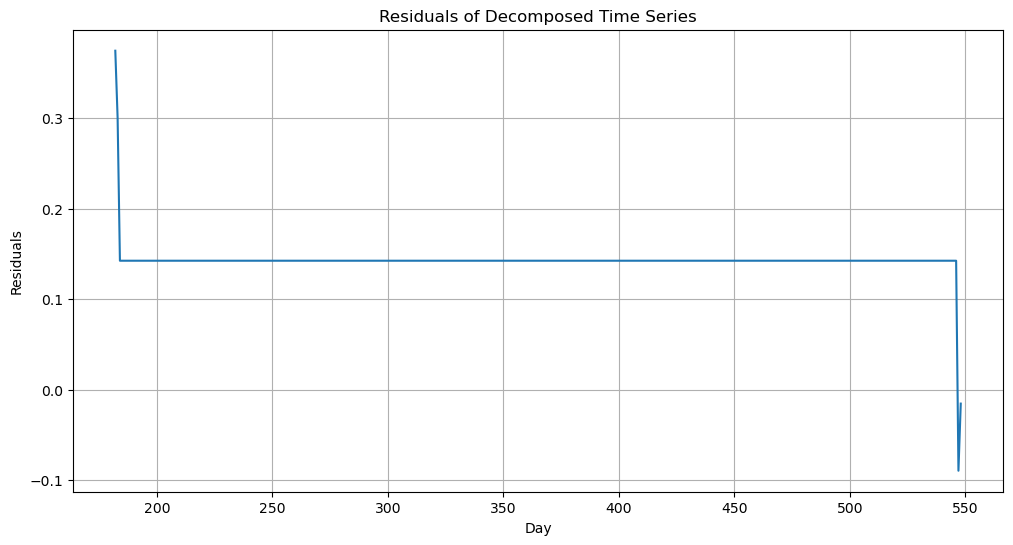

Residuals ADF Statistic: -12.362021927319837
Residuals p-value: 5.519275932513205e-23


In [104]:
# confirming lack of trends in the residuals
# plot residuals from decomposition
plt.figure(figsize=(12, 6))
plt.plot(decomposition.resid)
plt.title('Residuals of Decomposed Time Series')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# perform an ADF test on residuals to confirm stationarity
from statsmodels.tsa.stattools import adfuller
adf_result_resid = adfuller(decomposition.resid.dropna())
print(f'Residuals ADF Statistic: {adf_result_resid[0]}')
print(f'Residuals p-value: {adf_result_resid[1]}')

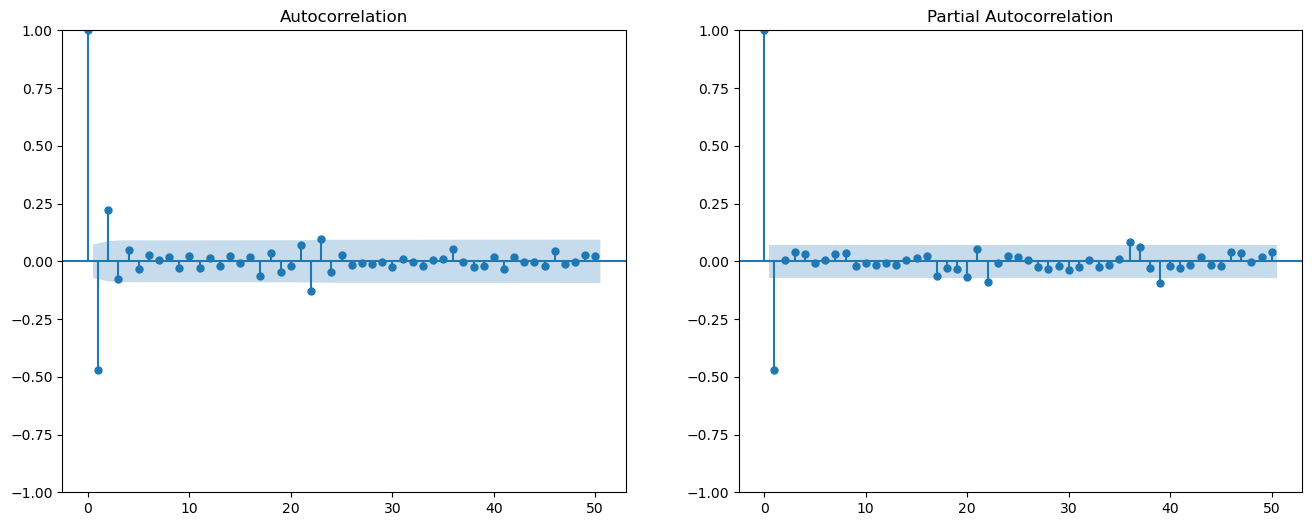

In [105]:
# differencing to make the series stationary
teleco_time_series['Revenue_diff'] = teleco_time_series['Revenue'].diff().dropna()

# plot the ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(teleco_time_series['Revenue_diff'].dropna(), lags=50, ax=ax[0])
plot_pacf(teleco_time_series['Revenue_diff'].dropna(), lags=50, ax=ax[1])
plt.show()

In [106]:
# fit the ARIMA(1,1,1) model
model = ARIMA(teleco_time_series['Revenue'], order=(1, 1, 1))
model_fit = model.fit()

# summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.326
Date:                Wed, 04 Sep 2024   AIC                            986.652
Time:                        17:18:11   BIC                           1000.431
Sample:                             0   HQIC                           991.968
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4804      0.068     -7.063      0.000      -0.614      -0.347
ma.L1          0.0176      0.077      0.227      0.821      -0.134       0.169
sigma2         0.2243      0.013     17.764      0.0

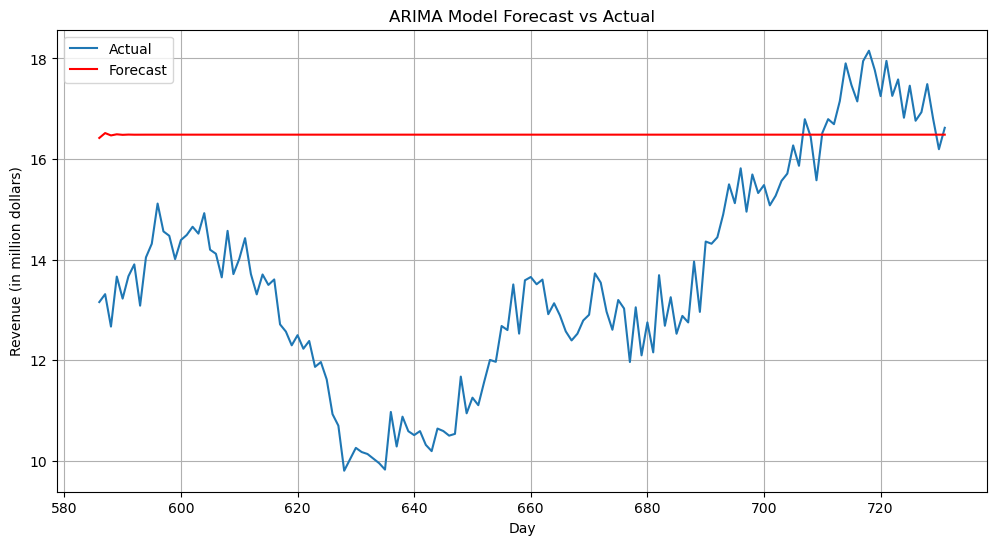

In [107]:
# forecast the next period 
forecast = model_fit.forecast(steps=len(test_set))

# plot the forecast against the actual test set values
plt.figure(figsize=(12, 6))
plt.plot(test_set['Day'], test_set['Revenue'], label='Actual')
plt.plot(test_set['Day'], forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Day')
plt.ylabel('Revenue (in million dollars)')
plt.legend()
plt.grid(True)
plt.show()

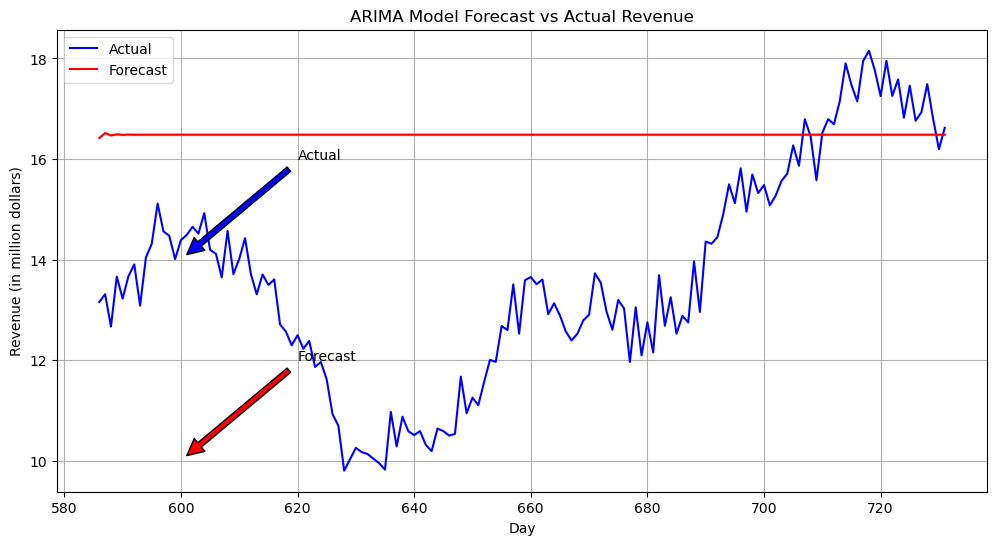

In [108]:
# forecast the next period 
forecast = model_fit.forecast(steps=len(test_set))

# plot the forecast against the actual test set values
plt.figure(figsize=(12, 6))
plt.plot(test_set['Day'], test_set['Revenue'], label='Actual', color='blue')
plt.plot(test_set['Day'], forecast, label='Forecast', color='red')
plt.fill_between(test_set['Day'], forecast - 1.96 * forecast.std(), forecast + 1.96 * forecast.std(), color='gray', alpha=0.3) # Adding confidence intervals
plt.title('ARIMA Model Forecast vs Actual Revenue')
plt.xlabel('Day')
plt.ylabel('Revenue (in million dollars)')
plt.legend()
plt.grid(True)
plt.annotate('Forecast', xy=(600, 10), xytext=(620, 12),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Actual', xy=(600, 14), xytext=(620, 16),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.show()